In [1]:
import rasterio
from rasterio import plot
from skimage.util import img_as_float
import skimage.io as skio
from skimage.transform import rescale, rotate
from skimage.exposure import rescale_intensity
from pathlib import Path
import numpy
import matplotlib.pyplot as plt
import zipfile
import xml.etree.ElementTree as ET
from tqdm import tqdm
from collections import OrderedDict
import pickle
import pyproj

import os
import sys

repo_path = str(Path().resolve().parent.parent)
os.chdir(repo_path)
sys.path.append(repo_path)

from src.satellite_image_processing.image_handler.general_image_handler import (
    GeneralImageHandler,
    BouctoucheImageHandler,
    CocagneImageHandler,
    WestImageHandler
)

In [2]:
#image_path = str(Path("data/sentinel2_data/bouctouche/S2A_MSIL2A_20220925T151701_N0400_R025_T20TLS_20220925T210422.zip"))
#image_path = str(Path("data/sentinel2_data/bouctouche/S2B_MSIL2A_20230511T152629_N0509_R068_T20TLS_20230511T211531.zip")) # Pas de nuage NB
#image_path = str(Path("data/sentinel2_data/bouctouche/S2B_MSIL2A_20230508T151659_N0509_R025_T20TLS_20230508T191124.zip")) # Un peu de Nuage Cocagne
image_path = str(Path("data/sentinel2_data/dunk/S2B_MSIL2A_20230528T151659_N0509_R025_T20TMS_20230528T191653.zip")) # West

In [3]:
general_image_handler = GeneralImageHandler(image_path)

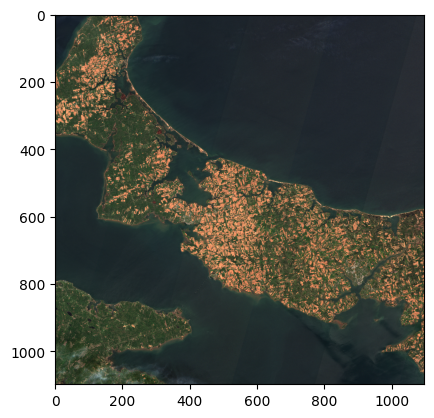

In [4]:
plt.imshow(general_image_handler.true_color_image)

In [6]:
bouctouche_image_handler = BouctoucheImageHandler(image_path)
cocagne_image_handler = CocagneImageHandler(image_path)

In [7]:
bouctouche_rgb = bouctouche_image_handler.get_rgb_float_true_color_image()
cocagne_rgb = cocagne_image_handler.get_rgb_float_true_color_image()

In [3]:
west_image_handler = WestImageHandler(image_path)

In [7]:
west_rgb = west_image_handler.true_color_image

In [4]:
def create_ndwi_raster(green_band, nir_band):
    green_band = green_band.astype(float)
    nir_band = nir_band.astype(float)
    ndwi = (green_band - nir_band)/(green_band + nir_band)
    return ndwi
def create_ndti_ras(red_band, green_band):
    red_band = red_band.astype(float)
    green_band = green_band.astype(float)
    ndti = (red_band - green_band)/(red_band + green_band)
    return ndti

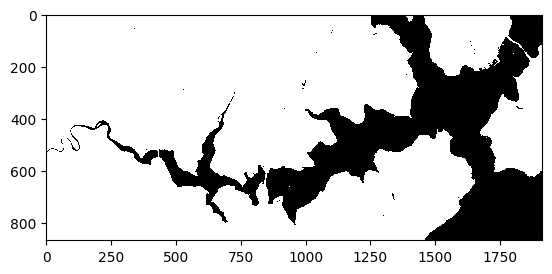

In [9]:
west_ndwi = create_ndwi_raster(west_image_handler.green_band, west_image_handler.nir_band)
west_water_mask = numpy.atleast_3d((west_ndwi > 0.01)*1)
west_water = west_water_mask*west_rgb
plt.imshow(west_water_mask, interpolation="nearest", cmap="Greys")

In [39]:
import skimage.io as skio

In [40]:
west_turb = skio.imread("WestTurb4.bmp")

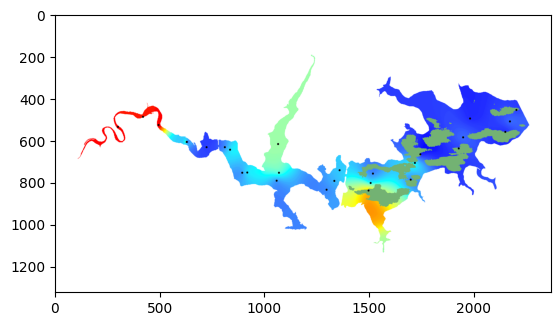

In [46]:
plt.imshow(west_turb)

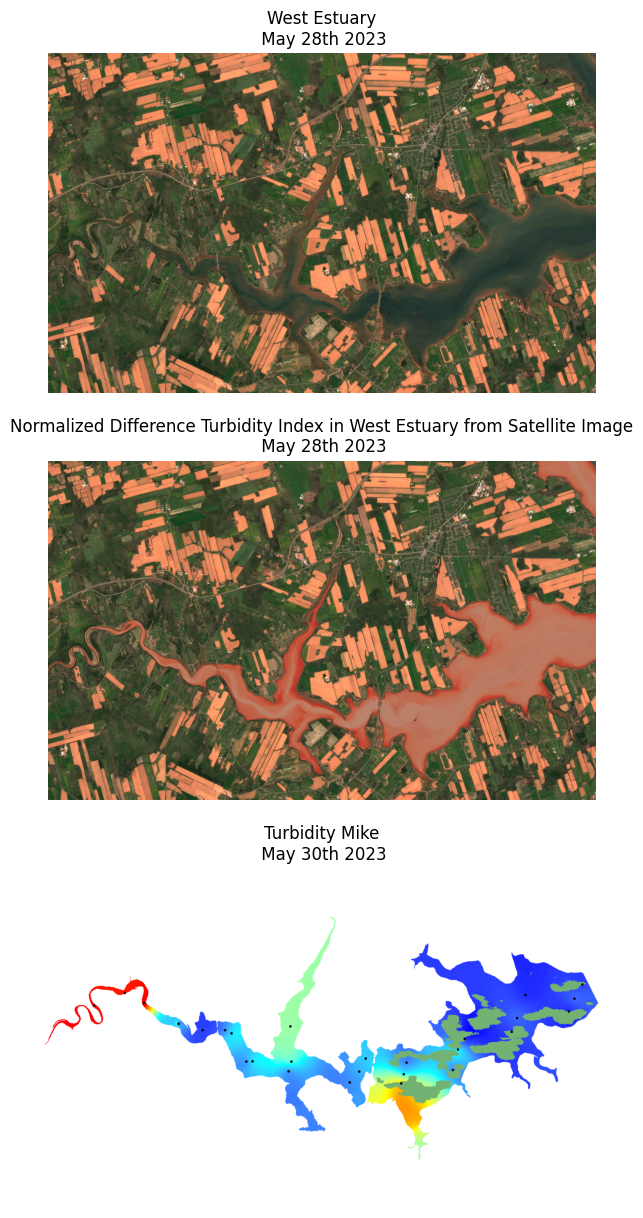

In [57]:
west_ndti = numpy.atleast_3d(create_ndti_ras(west_image_handler.red_band, west_image_handler.green_band))
west_alpha_array = (numpy.ones_like(west_water_mask)*0.70*west_water_mask)[:,:,0]
fig, axs = plt.subplots(3, 1, figsize=(15,15))
#plt.figure(figsize=(15,15))
axs[0].imshow(west_rgb[:, :1400, :])
axs[0].set_title("West Estuary\n May 28th 2023")
axs[1].imshow(west_rgb[:, :1400, :])
axs[1].imshow((west_ndti*west_water_mask)[:, :1400, :], cmap="Reds",alpha=west_alpha_array[:, :1400], vmin=-0.20, vmax=0.20)
axs[1].set_title("Normalized Difference Turbidity Index in West Estuary from Satellite Image\n May 28th 2023")
axs[2].imshow(west_turb)
axs[2].set_title("Turbidity Mike\n May 30th 2023")
for ax in axs:
    ax.axis("off")
plt.savefig("West_turb_satellite.jpg")
plt.show()

In [19]:
numpy.abs(west_ndti).min()

0.0

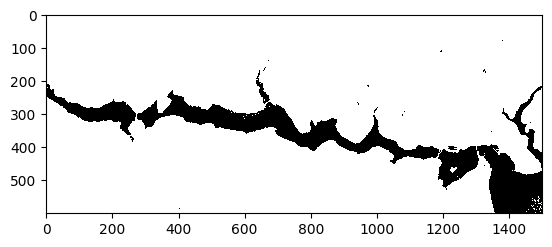

In [10]:
bouctouche_ndwi = create_ndwi_raster(bouctouche_image_handler.green_band, bouctouche_image_handler.nir_band)
bouctouche_water_mask = numpy.atleast_3d((bouctouche_ndwi > 0.01)*1)
bouctouche_water = bouctouche_water_mask*bouctouche_rgb
plt.imshow(bouctouche_water_mask[:600, :1500, :], interpolation="nearest", cmap="Greys")

In [11]:
from skimage.filters import gaussian


Text(0.5, 1.0, 'Normalized Difference Turbidity Index in Bouctouche Estuary')

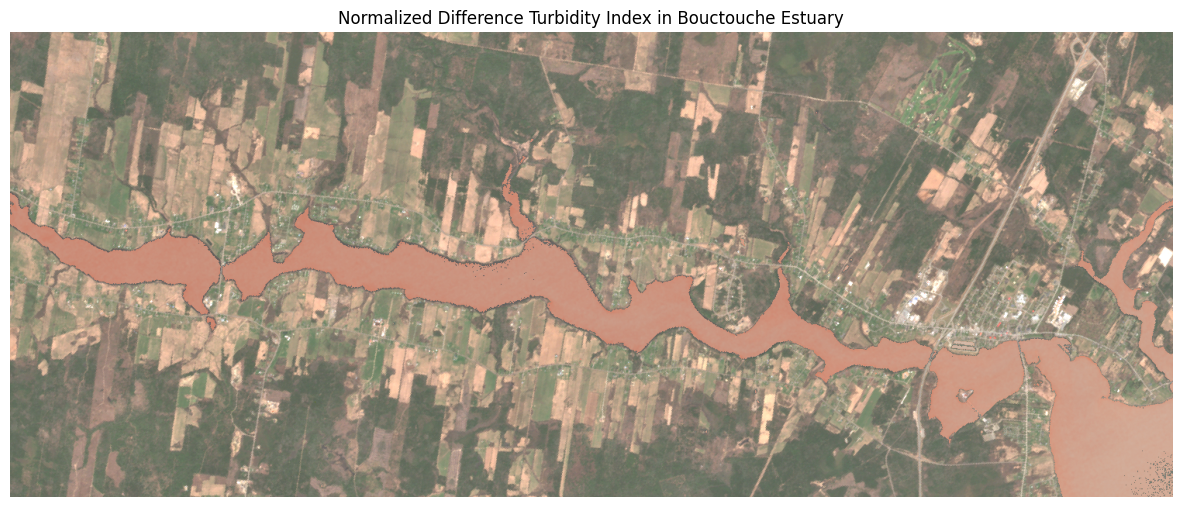

In [12]:
bouctouche_ndti = numpy.atleast_3d(create_ndti_ras(bouctouche_image_handler.red_band, bouctouche_image_handler.green_band))
bouctouche_alpha_array = (numpy.ones_like(bouctouche_water_mask)*0.70*bouctouche_water_mask)[:,:,0]
plt.figure(figsize=(15,15))
plt.imshow(bouctouche_rgb[:600, :1500, :])
plt.imshow(gaussian(bouctouche_ndti[:600, :1500])*bouctouche_water_mask[:600, :1500, :], cmap="Reds",alpha=bouctouche_alpha_array[:600, :1500], vmin=-0.15, vmax=0.35)
plt.axis("off")
plt.title("Normalized Difference Turbidity Index in Bouctouche Estuary")

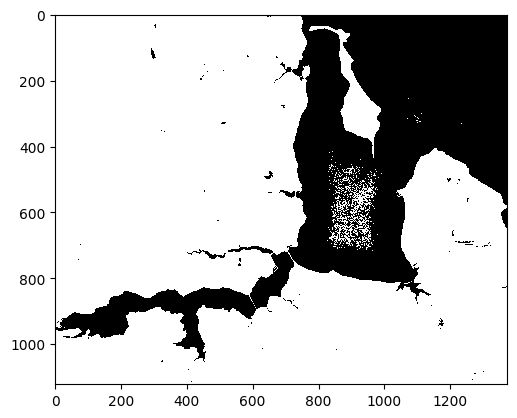

In [13]:
cocagne_ndwi = create_ndwi_raster(cocagne_image_handler.green_band, cocagne_image_handler.nir_band)
cocagne_water_mask = numpy.atleast_3d((cocagne_ndwi > 0.01)*1)
cocagne_water = cocagne_water_mask*cocagne_rgb
plt.imshow(cocagne_water_mask[:, :, :], interpolation="nearest", cmap="Greys")

Text(0.5, 1.0, 'Normalized Difference Turbidity Index in Cocagne Estuary')

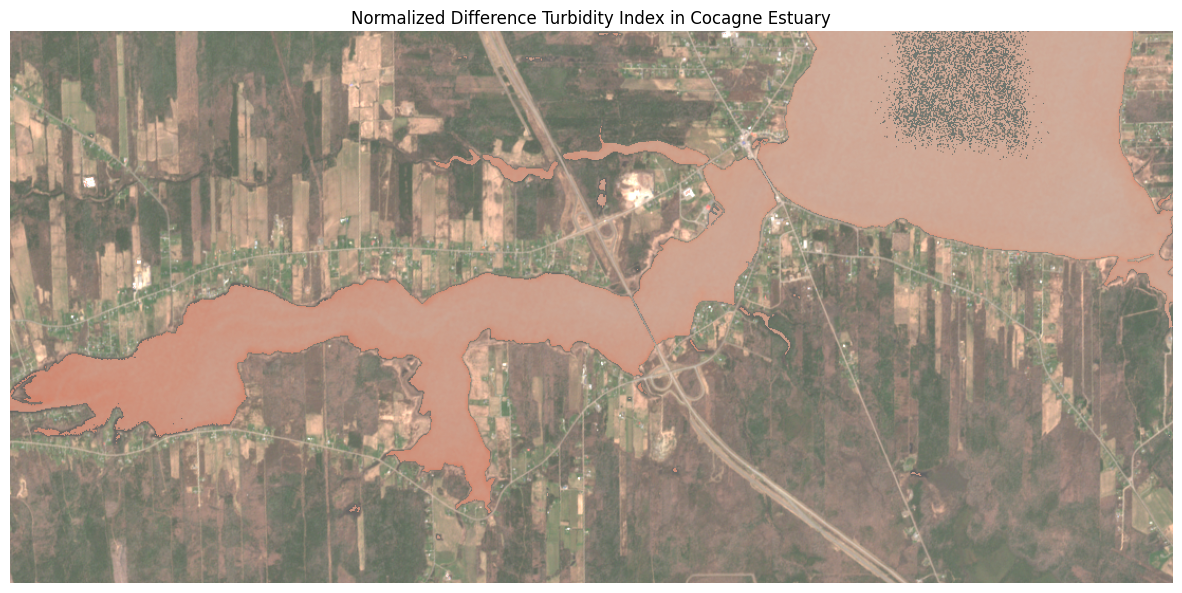

In [14]:
cocagne_ndti = numpy.atleast_3d(create_ndti_ras(cocagne_image_handler.red_band, cocagne_image_handler.green_band))
cocagne_alpha_array = (numpy.ones_like(cocagne_water_mask)*0.70*cocagne_water_mask)[:,:,0]
plt.figure(figsize=(15,15))
plt.imshow(cocagne_rgb[600:, :, :])
plt.imshow(gaussian(cocagne_ndti[600:, :1100, :])*cocagne_water_mask[600:, :1100, :], cmap="Reds",alpha=cocagne_alpha_array[600:, :1100], vmin=-0.15, vmax=0.35)
plt.axis("off")
plt.title("Normalized Difference Turbidity Index in Cocagne Estuary")

<function matplotlib.pyplot.show(close=None, block=None)>

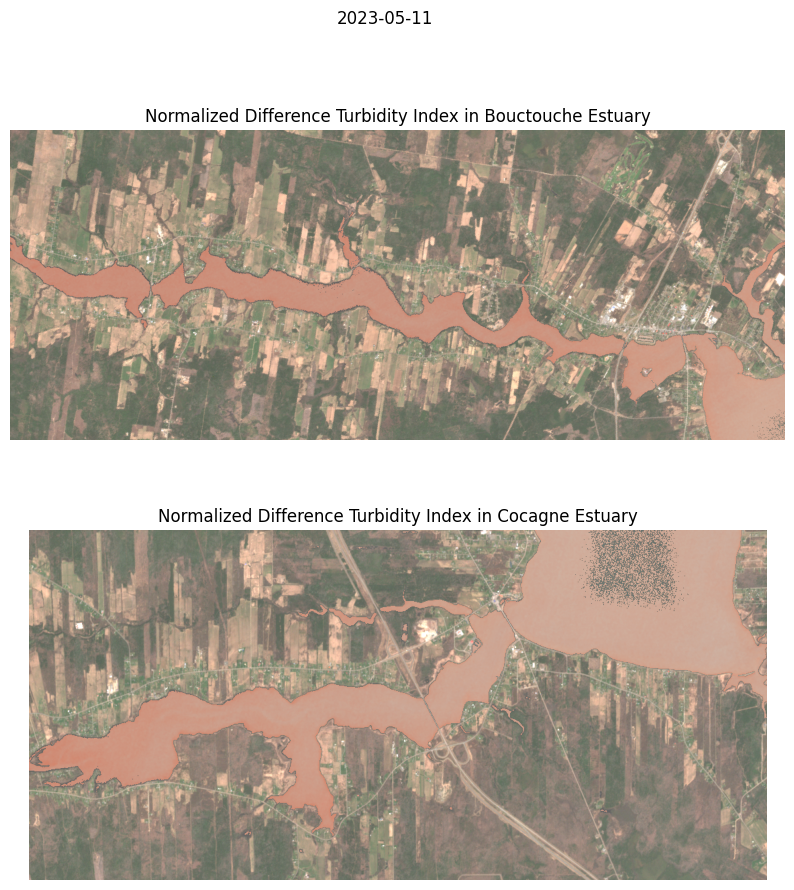

In [18]:
fig, axs = plt.subplots(2, 1, figsize=(10,10))
axs[0].imshow(bouctouche_rgb[:600, :1500, :])
axs[0].imshow(gaussian(bouctouche_ndti[:600, :1500])*bouctouche_water_mask[:600, :1500, :], cmap="Reds",alpha=bouctouche_alpha_array[:600, :1500], vmin=-0.15, vmax=0.35)
axs[0].axis("off")
axs[0].set_title("Normalized Difference Turbidity Index in Bouctouche Estuary")
axs[1].imshow(cocagne_rgb[600:, :, :])
axs[1].imshow(gaussian(cocagne_ndti[600:, :1100, :])*cocagne_water_mask[600:, :1100, :], cmap="Reds",alpha=cocagne_alpha_array[600:, :1100], vmin=-0.15, vmax=0.35)
axs[1].axis("off")
axs[1].set_title("Normalized Difference Turbidity Index in Cocagne Estuary")
fig.suptitle(bouctouche_image_handler.date.split("T")[0])
plt.savefig("Bouctouche vs Cocagne.png")
plt.show


In [24]:
sat_folder_list = list(filter(lambda path: ".zip" in str(path), list(Path("data/sentinel2_data/bouctouche").iterdir())))

In [34]:
from datetime import datetime

In [38]:
date = datetime.strptime(sat_folder_list[0].name.split("_")[2].split("T")[0], "%Y%m%d")

In [42]:
date.strftime("%Y-%m-%d")

'2022-05-01'

'20220501'

In [31]:
sat_folder_list[0]

WindowsPath('data/sentinel2_data/bouctouche/S2A_MSIL2A_20220501T152631_N0400_R068_T20TLS_20220501T203510.zip')

In [7]:
adcp_geo_coordinates = {
    "lat": 46.428958,
    "lon": -64.789768
}
turbidity_geo_coordinates = {
    "lat": 46.428697,
    "lon": -64.789029
}

In [8]:
row, col = image_handler.get_row_col_index_from_longitide_latitude(adcp_geo_coordinates["lon"], adcp_geo_coordinates["lat"])

AttributeError: 'function' object has no attribute 'apply_transformation_to_geocoordinates'